In [1]:
#################################################################
#
# Estimate pendulum state with EKF and ERTS as in Examples 5.1
# and 9.1 of the book
#
# Simo Sarkka (2013), Bayesian Filtering and Smoothing,
# Cambridge University Press. 
#
# Last updated: $Date: 2013/08/26 12:58:41 $.
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.
#
#################################################################

In [2]:
import numpy as np
from numpy.linalg import cholesky, solve

import plotly.graph_objects as go
from plotly.subplots import make_subplots

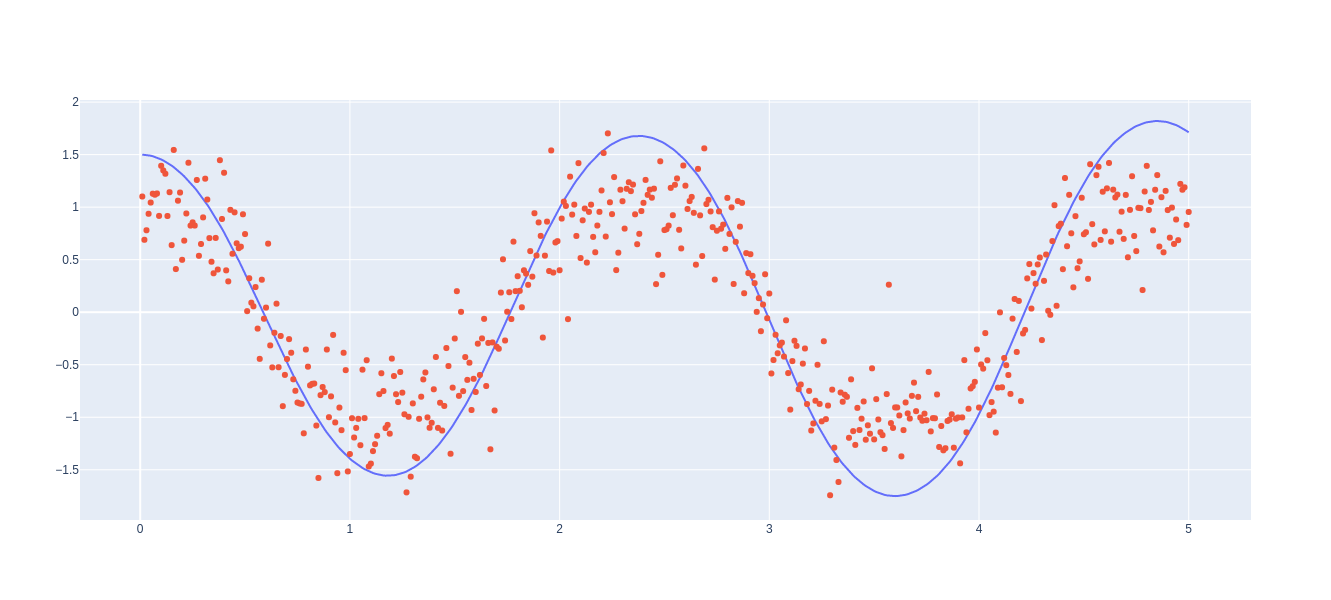

In [3]:
##
# Simulate data
##
from pendulum_sim import dt, T, m0, P0, Q, R, g, Y, X

In [4]:
##
# Filter
##

m = m0
P = P0

m_ = m.shape[0]
y_ = len(Y)
p_1, p_2 = P.shape

MM = np.zeros((y_,m_,1))
PP = np.zeros((y_,p_1,p_2))
for k in range(y_):
    f = np.array([m[0]+m[1]*dt, m[1]-g*np.sin(m[0])*dt])
    F = np.array([[1,                   dt], 
                  [-g*np.cos(m[0,0])*dt, 1]])
    m = f
    P = F@P@F.T + Q

    h = np.sin(m[0])
    H = np.array([np.cos(m[0,0]), 0])[None]
    S = H@P@H.T + R
    K = solve(S.T, H@P.T).T
    m += K@(Y[k] - h)
    P -= K@S@K.T

    MM[k] = m
    PP[k] = P


rmse_ekf = np.sqrt(np.mean((X[:,0,0]-MM[:,0,0])**2))
rmse_ekf

0.08913113508240604

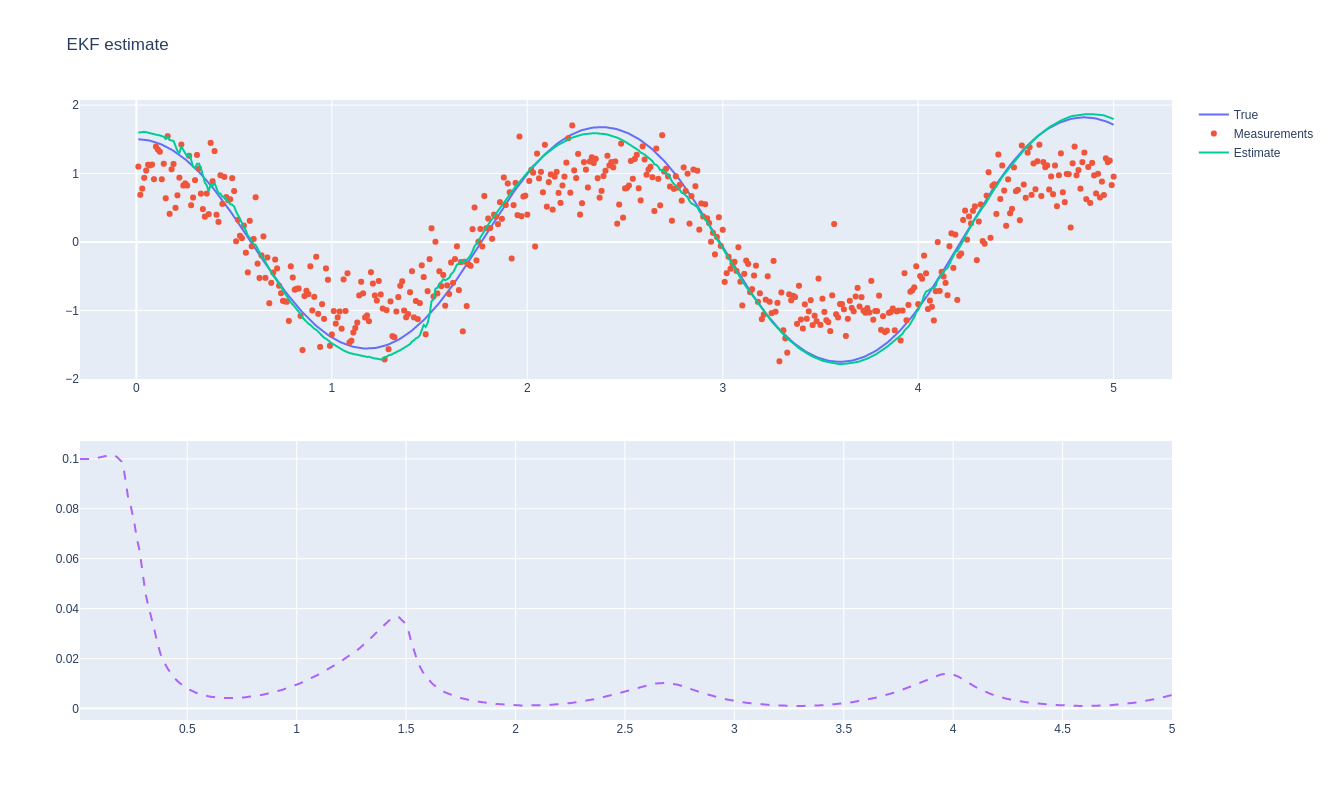

In [5]:
fig = go.Figure(make_subplots(rows=2,cols=1, vertical_spacing=0.1))
fig.add_scatter(x=T, y=X[:,0,0], name='True', row=1, col=1)
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements', row=1, col=1)
fig.add_scatter(x=T, y=MM[:,0,0], name='Estimate', row=1, col=1)
fig.add_scatter(x=T, y=PP[:,0,0], line_dash='dash', showlegend=False, row=2, col=1)
fig.layout.update(title='EKF estimate', height=800)
fig.show()

In [6]:
##
# Smoother
##

ms = m
Ps = P
MMS = np.zeros((y_,m_,1))
PPS = np.zeros((y_,p_1,p_2))
MMS[-1] = m
PPS[-1] = P
for k in range(y_-2,-1,-1):
    m = MM[k]
    P = PP[k]
    f = np.array([m[0]+m[1]*dt, m[1]-g*np.sin(m[0])*dt])
    F = np.array([[1,                   dt],
                  [-g*np.cos(m[0,0])*dt, 1]])

    mp = f
    Pp = F@P@F.T + Q
    Ck = solve(Pp.T, F@P.T).T
    ms = m + Ck@(ms - mp)
    Ps = P + Ck@(Ps - Pp)@Ck.T
    MMS[k] = ms
    PPS[k] = Ps


rmse_erts = np.sqrt(np.mean((X[:,0,0]-MMS[:,0,0])**2))
rmse_erts

0.02821195919449938

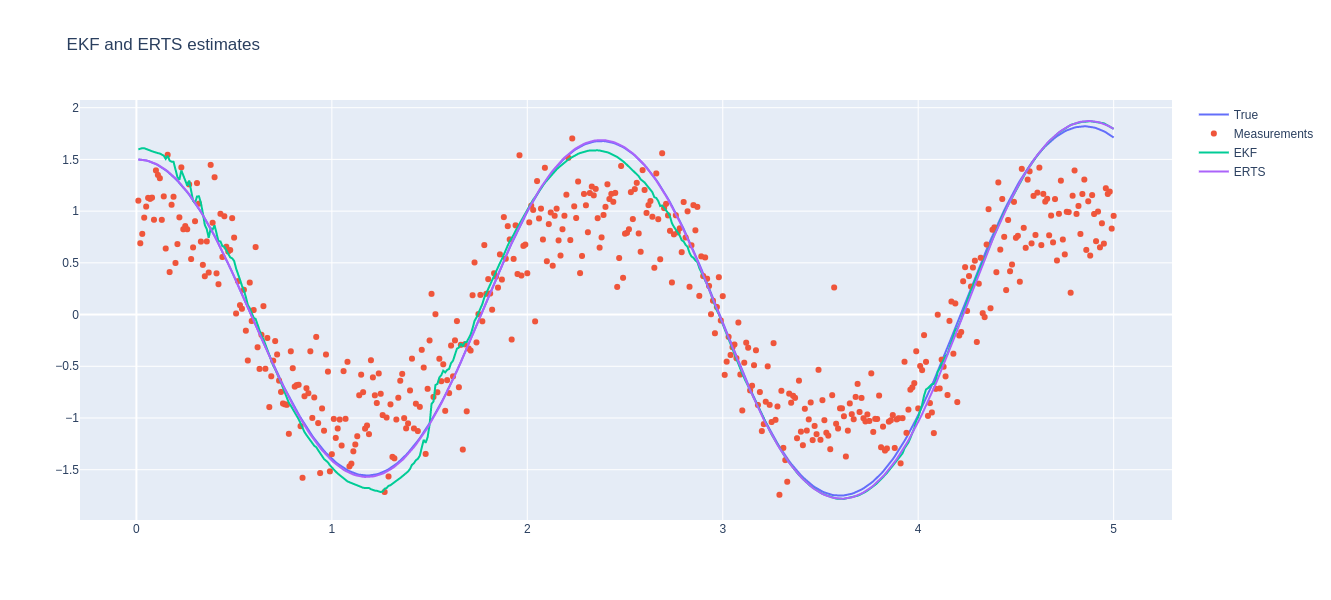

In [7]:
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MM[:,0,0], name='EKF')
fig.add_scatter(x=T, y=MMS[:,0,0], name='ERTS')
fig.layout.update(title='EKF and ERTS estimates', height=600)
fig.show()

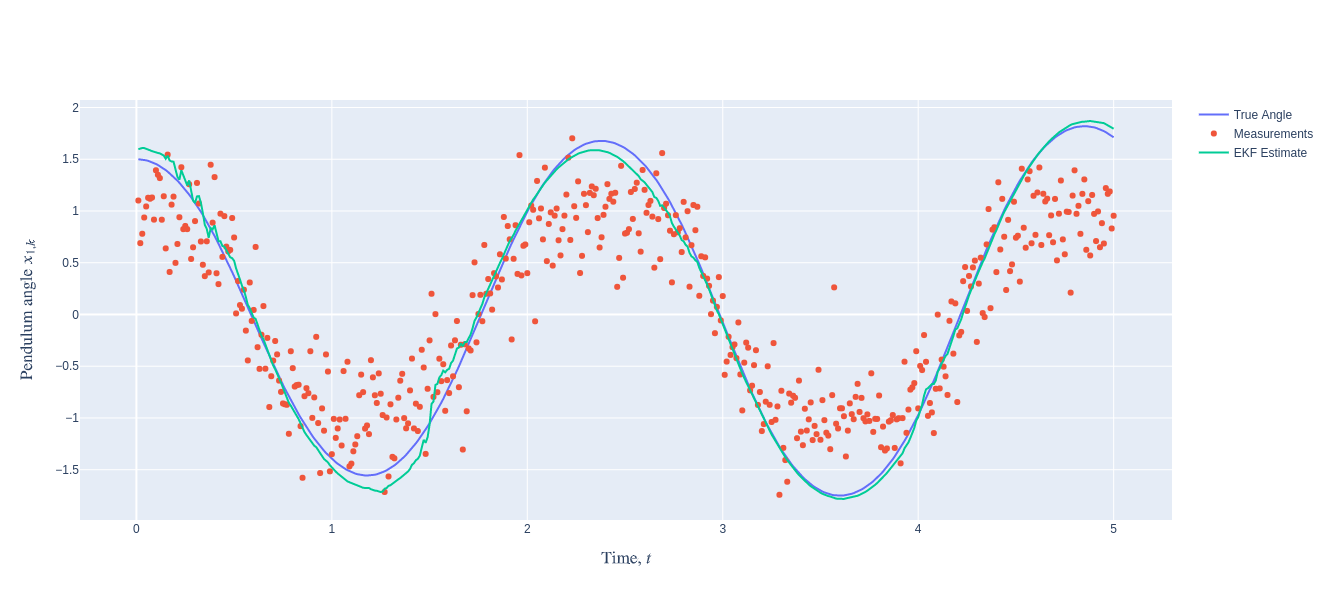

In [8]:
# Plot the filtering result
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True Angle')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MM[:,0,0], name='EKF Estimate')
fig.layout.update(xaxis_title='$\\text{Time, }t$', yaxis_title='$\\text{Pendulum angle }x_{1,k}$', height=600)
fig.show()

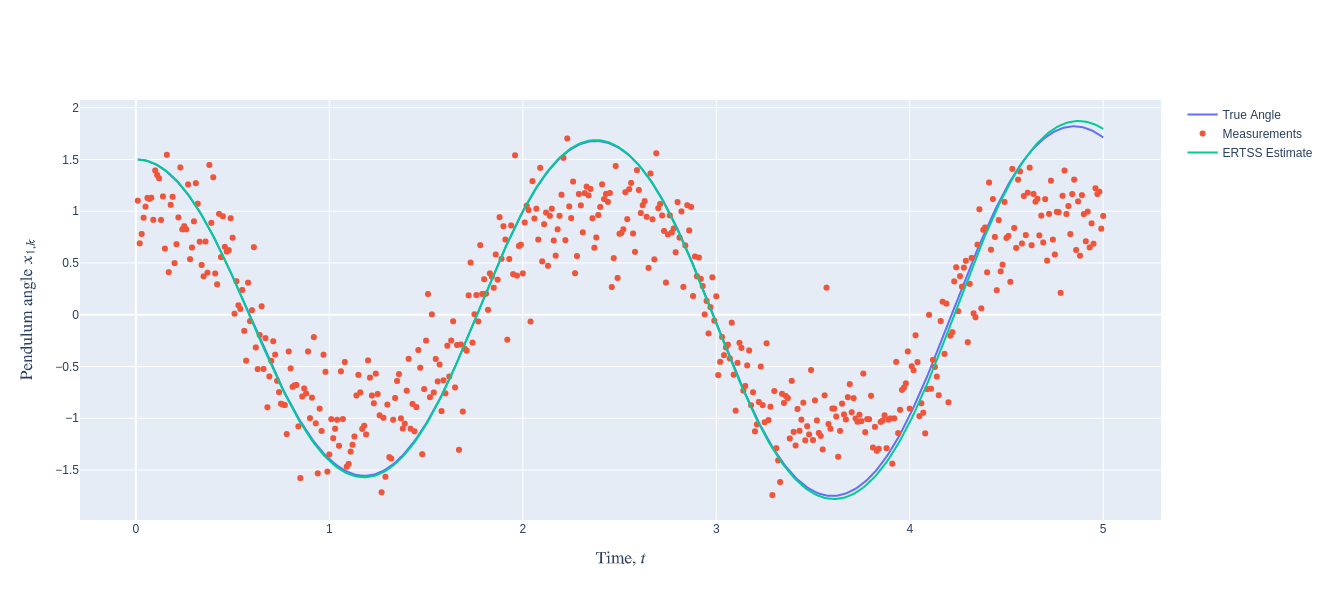

In [9]:
# Plot the smoothing result
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True Angle')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MMS[:,0,0], name='ERTSS Estimate')
fig.layout.update(xaxis_title='$\\text{Time, }t$', yaxis_title='$\\text{Pendulum angle }x_{1,k}$', height=600)
fig.show()